In [1]:
# A notebook for an exploration on the predictors for logistic and linear regression
# As well as 

In [22]:
import numpy as np
import os
import pandas as pd
from video_utils import CatVideo
import re
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from sklearn.linear_model import LogisticRegression

import seaborn as sn
import matplotlib.pyplot as plt
import cv2

In [23]:
x_headers = [
    "eye_ratio", "head_size", "ear_ratio", 
    "conf_head", "conf_eye_0", "conf_eye_1", 
    "conf_ear_0", "conf_ear_1", "conf_nose", "sharpness"
]

In [4]:
"""
Load up predictors and display them.
"""

predictors = np.loadtxt("x_results.txt")
predictors_df = pd.DataFrame(predictors, columns=x_headers)
display(predictors_df)

,eye_ratio,head_size,ear_ratio,conf_head,conf_eye_0,conf_eye_1,conf_ear_0,conf_ear_1,conf_nose,sharpness
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.285022,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.894592,0.000000,0.806655,0.000000,0.578450,0.000000
...,...,...,...,...,...,...,...,...,...,...
142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
143,0.872194,0.050633,0.000000,0.835639,0.913628,0.745760,0.700000,0.000000,0.659196,1801.518863
144,0.576636,0.053261,0.942257,0.346079,0.876601,0.869548,0.859990,0.651589,0.346202,191.416360
145,0.890909,0.045992,0.904147,0.644881,0.963726,0.678370,0.706430,0.690395,0.919236,329.533163


In [5]:
# Each item in X-headers is just a labeled image in the a random video
# A frame where none of the items are 0, no cat is detected.

In [6]:
frames_df = pd.read_csv("labeled_results_418.csv", names=["labeler", "video", "frame_seconds", "score"])
# Grab all frames where there's a cat
frames_df = frames_df[frames_df["score"] > 0].reset_index()
display(frames_df)

,index,labeler,video,frame_seconds,score
0,0,all,cat15.mp4,2.133385,2
1,1,all,cat74.mp4,13.984110,3
2,2,all,cat75.mp4,14.685697,2
3,3,all,cat21.mp4,2.282946,2
4,4,all,cat65.mp4,1.214871,4
...,...,...,...,...,...
142,156,all,cat35.mp4,3.484597,1
143,157,all,cat63.mp4,7.950350,4
144,158,all,cat30.mp4,3.723101,3
145,160,all,cat29.mp4,15.945570,5


In [7]:
all_df = pd.concat([predictors_df, frames_df], axis=1)

In [8]:
"""
Notes on the predictors

Conf_eye_0 is the maximum confidence amongst all eyes detected
Conf_eye_1 is the second-greatest confidence amongst all eyes detected
Conf_ear_0 is maximum confidence amongst all ears detected
Conf_ear_1 second greatest confidence
Conf_nose = maximum confidence in nose detected
eye_ratio is the ratio between size of eyes
head_size is the relative size of the head; bounding box of head divided by frame
sharpness is still using the Variance of the Laplacian

Create another feature: two eyes detected; in the final predictor set, use the highest eye confidence.
"""

'\nNotes on the predictors\n\nConf_eye_0 is the maximum confidence amongst all eyes detected\nConf_eye_1 is the second-greatest confidence amongst all eyes detected\nConf_ear_0 is maximum confidence amongst all ears detected\nConf_ear_1 second greatest confidence\nConf_nose = maximum confidence in nose detected\neye_ratio is the ratio between size of eyes\nhead_size is the relative size of the head; bounding box of head divided by frame\nsharpness is still using the Variance of the Laplacian\n\nCreate another feature: two eyes detected; in the final predictor set, use the highest eye confidence.\n'

In [9]:
# Keep only items where all features are detected.

# Here are Andrew's initial coefficients, mapping to the order of what is returned in the function in process_video.py
model_params_lin = np.load("model_params/lin_params.npy")

In [10]:
all_df = pd.concat([predictors_df, frames_df], axis=1).reset_index()
all_df["two_eyes_detected"] = np.logical_and(all_df["conf_eye_1"] > 0.3, all_df["conf_eye_0"] > 0.3)

# Sum all columns for a given row, and if anything is greater than 0, use the row
all_df["sum"] = all_df[x_headers].sum(axis=1)
all_df = all_df[all_df["sum"] > 0]

In [11]:
x_headers.append("two_eyes_detected")
corrMatrix = pd.DataFrame.corr(all_df[x_headers])

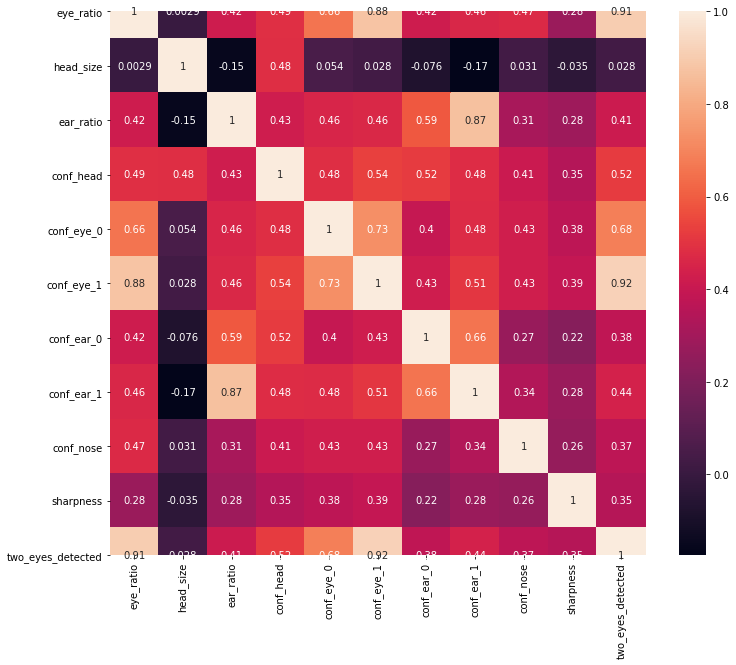

In [12]:
plt.figure(figsize=(12, 10))
sn.heatmap(corrMatrix, annot=True)
plt.show()
# TODO: Make the lables show better

In [13]:
# This correlation matrix tells us that we need to throw out one of the eyes
all_df.drop(columns=["two_eyes_detected", "conf_eye_1"])

,level_0,eye_ratio,head_size,ear_ratio,conf_head,conf_eye_0,conf_ear_0,conf_ear_1,conf_nose,sharpness,index,labeler,video,frame_seconds,score,sum
1,1,0.000000,0.000000,0.000000,0.000000,0.285022,0.000000,0.000000,0.000000,0.000000,1,all,cat74.mp4,13.984110,3,0.285022
4,4,0.000000,0.000000,0.000000,0.000000,0.894592,0.806655,0.000000,0.578450,0.000000,4,all,cat65.mp4,1.214871,4,2.279698
5,5,0.874559,0.086370,0.510148,0.926741,0.938150,0.984550,0.749880,0.921693,3804.388135,5,all,cat50.mp4,10.887835,5,3811.267757
7,7,0.505956,0.375955,0.000000,0.708893,0.890296,0.000000,0.000000,0.000000,101.188138,8,all,cat70.mp4,0.742923,2,104.229387
8,8,0.926471,0.071832,0.000000,0.839750,0.535549,0.784741,0.000000,0.957674,324.393783,9,all,cat59.mp4,25.081704,5,329.024491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,141,0.904503,0.043359,0.739871,0.611578,0.965323,0.705076,0.652227,0.893234,358.161315,155,all,cat29.mp4,17.440915,5,364.424904
143,143,0.872194,0.050633,0.000000,0.835639,0.913628,0.700000,0.000000,0.659196,1801.518863,157,all,cat63.mp4,7.950350,4,1806.295911
144,144,0.576636,0.053261,0.942257,0.346079,0.876601,0.859990,0.651589,0.346202,191.416360,158,all,cat30.mp4,3.723101,3,196.938522
145,145,0.890909,0.045992,0.904147,0.644881,0.963726,0.706430,0.690395,0.919236,329.533163,160,all,cat29.mp4,15.945570,5,335.977250


In [14]:
model_logistic = LogisticRegression(penalty="l1")
model_logistic.fit(all_df[x_headers], all_df["score"])

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
results = model_logistic.predict(all_df[x_headers])

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(all_df["score"], results)

0.6020408163265306

In [18]:
"""
Things left to do
"""

"""
1. Look through the 5s, see waht other features you think would make it look good
2. Systematically test all our features and look at how it changes the test accuracy - Emily TODO (start)
3. Color brightness / saturation - Emily TODO (today?)
4. Detect cat and check where it is on the frame?
5. Relative size of cat according to segmentation: ratio of cat to non-cat - Emily TODO (today?)

"""

'\n1. Look through the 5s, see waht other features you think would make it look good\n2. Systematically test all our features and look at how it changes the test accuracy - Emily TODO (start)\n3. Color brightness / saturation - Emily TODO (today?)\n4. Detect cat and check where it is on the frame?\n5. Relative size of cat according to segmentation: ratio of cat to non-cat - Emily TODO (today?)\n\n'

In [19]:
### ATTEMPTING A CONVOLUTIONAL NEURAL NET

In [20]:
train = True
epochs = 5  # number of epochs to train models
input_size = (64, 64, 3)

In [40]:
from PIL import Image

"""
First, let's sort the videos by frame, so that we don't have to load a new video instance unnecessarily.

Then, we'll loop through each item here and recover all of the labelled frames, grab the images, and store them as files.
"""
frames_cnn = frames_df.copy()

# Add a column to store the image data
frames_cnn["images"] = None

"""
Populate our dataframe with the data from labeled images.
"""
video_filepath = "videos"
for i, row in frames_cnn.iterrows():
    try:
        video_file = row["video"]
        cat_video = CatVideo(f"{video_filepath}/{video_file}")
        frame = cat_video.get_frame_time(row["frame_seconds"])
        frames_cnn["images"][i] = frame
        """
        Also save the image in case we want to use it later.
        """
        im = Image.fromarray(frame)
        video_name = video_file.split(".mp4")[0]
        im.save(f"frames/{frames_cnn.index[i]}_{video_name}.png")
    except:
        print(f"Did not work for: {video_filepath}/{video_file}")
        print(row["frame_seconds"])

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Emily/opt/anaconda3/lib/python3.7/site-packages/ipykernel_la

In [42]:
frames_cnn.head()

"""
Cast the images loaded into the dataframes as numpy arrays
"""
numpy_images = frames_cnn["images"].to_numpy()

,index,labeler,video,frame_seconds,score,images
0,0,all,cat15.mp4,2.133385,2,"[[[84, 40, 39], [84, 40, 39], [87, 40, 40], [8..."
1,1,all,cat74.mp4,13.984110,3,"[[[62, 51, 57], [62, 51, 57], [62, 51, 57], [6..."
2,2,all,cat75.mp4,14.685697,2,"[[[230, 141, 91], [230, 141, 91], [230, 141, 9..."
3,3,all,cat21.mp4,2.282946,2,"[[[10, 2, 0], [11, 3, 0], [12, 4, 0], [12, 4, ..."
4,4,all,cat65.mp4,1.214871,4,"[[[130, 118, 119], [130, 118, 119], [130, 118,..."


(array([  2.,   0.,   0.,   0.,   0.,   0., 143.,   0.,   0.,   2.]),
 array([1.25      , 1.33012821, 1.41025641, 1.49038462, 1.57051282,
        1.65064103, 1.73076923, 1.81089744, 1.89102564, 1.97115385,
        2.05128205]),
 <a list of 10 Patch objects>)

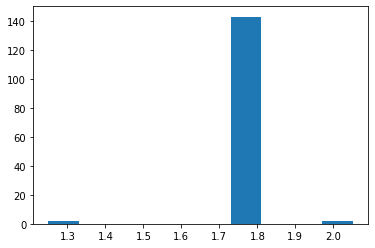

In [55]:
"""
Do some very brief EDA to see the max and min dimensions on the images, 
to get a sense of how I should crop or resize.
"""
aspect_ratios = []

for image_array in numpy_images:
    if image_array.shape[0] >  image_array.shape[1]:
        aspect_ratios.append(image_array.shape[0] / image_array.shape[1])
    else:
        aspect_ratios.append(image_array.shape[1] / image_array.shape[0])

plt.hist(aspect_ratios)

In [63]:
"""
Since most of the images are the same aspect ratio, let's just skip over images that are  *not* the same
aspect ratio of the majority of images for now.

Then rotate to orient them all the same direction. I don't think it will matter what orientation the images are.
"""
frames_cnn["aspect_ratios"] = np.array(aspect_ratios)
frames_cnn.head()

,index,labeler,video,frame_seconds,score,images,aspect_ratios
0,0,all,cat15.mp4,2.133385,2,"[[[84, 40, 39], [84, 40, 39], [87, 40, 40], [8...",1.777778
1,1,all,cat74.mp4,13.984110,3,"[[[62, 51, 57], [62, 51, 57], [62, 51, 57], [6...",1.773399
2,2,all,cat75.mp4,14.685697,2,"[[[230, 141, 91], [230, 141, 91], [230, 141, 9...",1.773399
3,3,all,cat21.mp4,2.282946,2,"[[[10, 2, 0], [11, 3, 0], [12, 4, 0], [12, 4, ...",1.777778
4,4,all,cat65.mp4,1.214871,4,"[[[130, 118, 119], [130, 118, 119], [130, 118,...",1.777778


In [72]:
numpy_images[0].shape

(1920, 1080, 3)

In [80]:
"""
Let's lay all the images horizontally and line up their 
"""
images_horizontal = []
for image_array in numpy_images:
    """
    If image is vertical, rotate it 90 degrees.
    Since images are always: height, width, depth
    """
    if image_array.shape[0] >  image_array.shape[1]:
        image_array = np.rot90(image_array)
    images_horizontal.append(image_array)

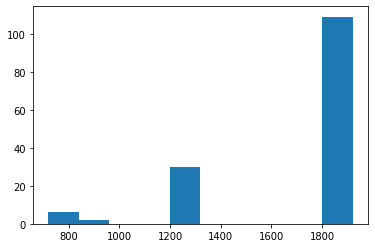

In [92]:
widths = [x.shape[1] for x in images_horizontal]
plt.hist(widths)
minimum_width_image = images_horizontal[np.argmin(widths)]
"""
The minimum width image is still an aspect ratio of ~16:9
"""
minimum_width_image.shape[1] / minimum_width_image.shape[0]

In [96]:
# """
# Since so few images are *NOT* ~1.77 aspect ratio, we'll leave those out 
# for convenience purposes in getting a simple CNN running.

# Additionally, some of them are off by a little. We'll include those and be sure to crop a bit to make it fit.
# """

# frames_cnn["aspect_ratios"] = np.round_(aspect_ratios)

In [97]:

print(minimum_width_image.shape[1])
print(minimum_width_image.shape[0])

720
406


In [116]:
"""
Citation: This is adapted from the data science labs.
"""
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()


recrop_size = (720, 406)

def tf_norm_crop_resize_image(image, resize_dim):
    """Normalizes image to [0.,1.], crops to dims (720, 406, 3)
    and resizes to `resize_dim`, returning an image tensor."""
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize_with_crop_or_pad(image, 720, 406)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

for image in numpy_images:
    cropped_image = tf_norm_crop_resize_image(image, recrop_size)
    print(cropped_image.numpy())
    import sys; sys.exit()
    if round(image.shape[1] / image.shape[0], 2) != 1.77:
        plt.imshow(image)

ValueError: tf.enable_eager_execution must be called at program startup.

<Figure size 432x288 with 0 Axes>

In [ ]:
"""
Yeah he said we should try a simple one with a Conv layer, a MaxPool layer, and a dropout layer


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
"""

cnn_model = Sequential()

# 1st convolutional layer
cnn_model.add(Conv2D(
    filters=num_filters[0], 
    kernel_size=(3, 3),
    activation='relu',
    padding="same", 
    input_shape=sample_image.shape
  )
)

# 2nd convolutional layer + max pooling
cnn_model.add(Conv2D(
    filters=num_filters[1], 
    kernel_size=(3, 3),
    activation='relu',
    padding="same", 
  )
)
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.30))


# Output:
cnn_model.add(Dense(5, activation='softmax'))

# Compile model
cnn_model.compile(
    optimizer=Adam(lr=0.001),
    # Since we did not one-hot encode this, we'll use sparse categorical crossentropy
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"]
)

history = cnn_model.fit(
    x_train_norm,
    y_train,
    epochs=15,
    verbose=1, 
    validation_split=0.2,
)